In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import pycountry
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import logging
logging.root.setLevel(10)
import seaborn as sns; sns.set_theme()

import sys
import json
import os
sys.path.insert(0, os.path.realpath('..'))
os.chdir('..')

from src import data
from src.model import get_splits
with open('config.json', 'r') as cfg:
    config = json.load(cfg)
    
random_seed = 42

In [20]:
#!pip install tueplots
from tueplots import bundles
# global change:
plt.rcParams.update(bundles.neurips2021(usetex=False))

In [21]:
def get_country_name(code):
    country = pycountry.countries.get(alpha_3=code)
    return country.name if country else None


def load_data(config, get_top_level_categories=False):
    return_columns = [
        "Country code", "Country", "Function code", "Function", "Year",
        'Percentage of total expenditure', 'Total expenditure per capita (1000s USD)',
        'Expenditure per capita (1000s USD)', 'Happiness score',
    ]
    data_path = config["data_location"]
    cofog = pd.read_csv(data_path + config["cofog_dataset"])
    happiness = pd.read_csv(data_path + config["happiness_dataset"], sep=';')
    total_spending = pd.read_csv(data_path + config["total_spending_dataset"])

    # Normalize OECD data to percentages of total instead of millions

    cofog.rename(columns={
        "LOCATION": "Country code",
        "ACTIVITY": "Function code"
    }, inplace=True)
    if get_top_level_categories:
        cofog = cofog[cofog["Function code"].str.len() == 3]
    else:
        cofog = cofog[cofog["Function code"].str.len() > 3]

    # Clean-up - null negative expenditures before, which don't make sense, before summing
    cofog.loc[cofog['Value'] < 0, 'Value'] = 0
    totals = cofog.groupby(["Country", "Year"], as_index=False)["Value"].sum()

    cofog = pd.merge(cofog, totals, on=["Country", "Year"])
    cofog = cofog.rename(columns={"Value_x": "Value", "Value_y": "Total expenditure"})
    cofog["Percentage of total expenditure"] = cofog["Value"]/cofog["Total expenditure"]

    # Calculate expenditure per capita in 1000s of USD
    total_spending["Country"] = total_spending["LOCATION"].apply(get_country_name)
    total_spending = total_spending.rename(columns={"TIME": "Year"})
    cofog_merged = pd.merge(cofog, total_spending[["Country", "Year", "Value"]], on=["Country", "Year"])
    cofog_merged = cofog_merged.rename(columns={"Value_y": "Total expenditure per capita (1000s USD)"})
    cofog_merged["Expenditure per capita (1000s USD)"] = \
        cofog_merged["Percentage of total expenditure"]*cofog_merged["Total expenditure per capita (1000s USD)"]

    # Merge in happiness scores
    happiness = happiness.rename(columns={"Country name": "Country", "year": "Year", "Life Ladder": "Happiness score"})
    happiness["Happiness score"] = pd.to_numeric(happiness["Happiness score"].str.replace(',', '.'))
    return pd.merge(cofog_merged, happiness, on=["Country", "Year"])[return_columns]


def filter_bad_data(data):
    essential_columns = ["Year", "Total expenditure per capita (1000s USD)", "Happiness score"]
    non_negative_columns = ['Percentage of total expenditure', 'Expenditure per capita (1000s USD)']

    data_rows_cnt = len(data.index)
    data.dropna(inplace=True)
    logging.info("Dropped {n} rows with NaN values".format(n=data_rows_cnt - len(data.index)))
    data_rows_cnt = len(data.index)

    data = data[(data != "").any(axis=1)]
    logging.info("Dropped {n} rows with empty string values".format(n=data_rows_cnt - len(data.index)))
    data_rows_cnt = len(data.index)

    data = data[(data[essential_columns] > 0).any(axis=1)]
    logging.info("Dropped {n} rows with invalid essential columns".format(n=data_rows_cnt - len(data.index)))

    assert not data.isnull().any().any()
    assert not (data == "").any().any()
    assert not (data[essential_columns] <= 0).any().any()
    return data


def create_samples(data):
    """Transforms data into samples with expenditures for each function as a column

    Return a tuple - first element has 'Percentage of total expenditure' as features values, second has
    'Expenditure per capita (1000s USD).'"""
    def make_samples(value_column):
        # Make Function Code values into columns
        pivoted = data.pivot(index=['Country', 'Year'], columns=['Function code'], values=[value_column])

        # Clean up structure
        pivoted.columns = pivoted.columns.get_level_values(1)
        pivoted = pivoted.reset_index()
        pivoted.columns.name = None

        # Missing Country, Year, Function code combinations get nulled
        pivoted = pivoted.where(~pivoted.isnull(), 0)

        return pd.merge(pivoted, data[
            ['Country', 'Year', 'Total expenditure per capita (1000s USD)', 'Happiness score']
        ].drop_duplicates(), on=['Country', 'Year'])

    return make_samples('Percentage of total expenditure'), make_samples('Expenditure per capita (1000s USD)')


In [22]:
whole_data = load_data(config)
whole_data = filter_bad_data(whole_data)
print(whole_data)

INFO:root:Dropped 0 rows with NaN values
INFO:root:Dropped 0 rows with empty string values
INFO:root:Dropped 0 rows with invalid essential columns


      Country code    Country Function code  \
0              AUT    Austria          0101   
1              AUT    Austria          0201   
...            ...        ...           ...   
22109          AUS  Australia          0409   
22110          AUS  Australia          1009   

                                                Function  Year  \
0      Executive and legislative organs, financial, f...  2008   
1                                       Military defence  2008   
...                                                  ...   ...   
22109                            Economic affairs n.e.c.  2019   
22110                           Social protection n.e.c.  2019   

       Percentage of total expenditure  \
0                             0.045191   
1                             0.016489   
...                                ...   
22109                         0.005009   
22110                         0.010793   

       Total expenditure per capita (1000s USD)  \
0               

Text(0, 0.5, 'Happiness score')

DEBUG:matplotlib.figure:Executing constrainedlayout
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000147.ss000148.ax000149, (left: 0.000) (bot: 0.000) (right: 0.000) (top: 0.000)
DEBUG:matplotlib._constrained_layout:left 0.062115
DEBUG:matplotlib._constrained_layout:right 0.004630
DEBUG:matplotlib._constrained_layout:bottom 0.084491
DEBUG:matplotlib._constrained_layout:bbox.y0 0.047454
DEBUG:matplotlib._constrained_layout:pos.y0 0.125000
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000147.ss000148.ax000149, (left: 0.000) (bot: 0.000) (right: 1.000) (top: 1.000)
DEBUG:matplotlib._constrained_layout:left 0.062115
DEBUG:matplotlib._constrained_layout:right 0.004630
DEBUG:matplotlib._constrained_layout:bottom 0.084491
DEBUG:matplotlib._constrained_layout:bbox.y0 0.006945
DEBUG:matplotlib._constrained_layout:pos.y0 0.084491
DEBUG:matplotlib.figure:Executing constrainedlayout
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000147.ss000148.ax000149, (left: 0.000) 

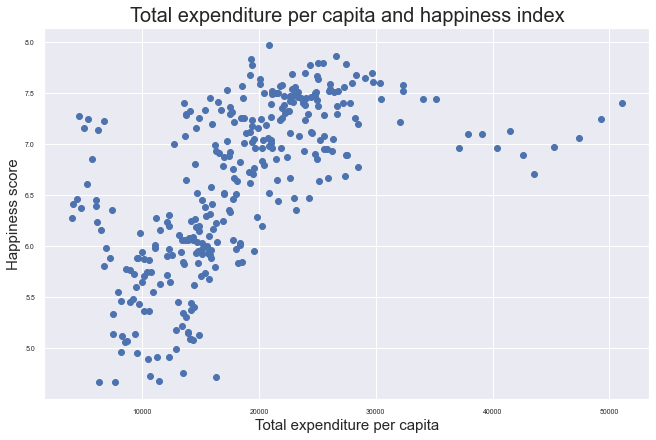

In [59]:
#scatter plot of total expenditure per capita and happiness score
unique_total_exp = whole_data.groupby(['Country code', 'Year'])["Total expenditure per capita (1000s USD)"].mean()
unique_happiness_index = whole_data.groupby(['Country code', 'Year'])["Happiness score"].mean()
fig=plt.figure(figsize=(9,6))
plt.scatter(unique_total_exp, unique_happiness_index)
plt.title("Total expenditure per capita and happiness index", fontsize = 20)
plt.xlabel("Total expenditure per capita", fontsize = 15)
plt.ylabel("Happiness score", fontsize = 15)

DEBUG:matplotlib.figure:Executing constrainedlayout
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000150.ss000151.ax000152, (left: 0.000) (bot: 0.000) (right: 0.000) (top: 0.000)
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397

DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplot

DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03

DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplot

DEBUG:matplotlib.figure:Executing constrainedlayout
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000150.ss000151.ax000152, (left: 0.000) (bot: 0.000) (right: 1.000) (top: 1.000)
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397

DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplot

DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03

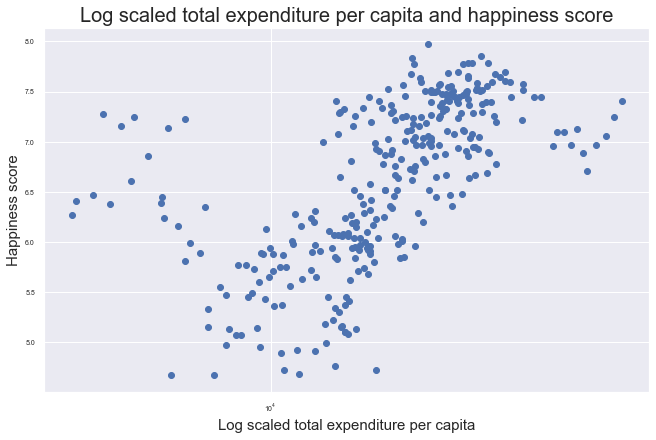

In [60]:
#log scaled scatter plot of total expenditure per capita and happiness score
fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(unique_total_exp, unique_happiness_index)
ax.set_xscale("log")
ax.set_xlabel("Log scaled total expenditure per capita", fontsize = 15)
ax.set_ylabel("Happiness score", fontsize = 15)
ax.set_title("Log scaled total expenditure per capita and happiness score", fontsize = 20)

plt.show()

In [48]:
#df.groupby(['city', 'food']).mean()
#whole_data.groupby(['Country code', 'Year'])["Total expenditure per capita (1000s USD)"].mean()
print(whole_data['Function code'].unique())
print(whole_data['Function code'][0][0:2])

['0101' '0201' '0301' '0401' '0501' '0601' '0701' '0801' '0901' '1001'
 '0102' '0202' '0302' '0402' '0502' '0602' '0702' '0802' '0902' '0203'
 '0303' '0403' '0503' '0603' '0703' '0803' '0903' '1003' '0104' '0204'
 '0304' '0404' '0504' '0604' '0704' '0804' '0904' '1004' '0105' '0205'
 '0305' '0405' '0505' '0605' '0705' '0805' '0905' '1005' '0306' '0406'
 '0506' '0606' '0706' '1006' '0107' '0108' '0407' '0908' '1008' '0409'
 '1009' '0103' '1002' '0408' '0806' '0106' '0907' '1007' '0906']
01


In [49]:
main_category_code = []
for i, sub_category_code in enumerate(whole_data['Function code']):
    main_category_code.append(whole_data['Function code'][i][0:2])
    
#print(main_category_code)
whole_data = whole_data.assign(Mainfunctioncode=main_category_code)
print(whole_data)

      Country code    Country Function code  \
0              AUT    Austria          0101   
1              AUT    Austria          0201   
...            ...        ...           ...   
22109          AUS  Australia          0409   
22110          AUS  Australia          1009   

                                                Function  Year  \
0      Executive and legislative organs, financial, f...  2008   
1                                       Military defence  2008   
...                                                  ...   ...   
22109                            Economic affairs n.e.c.  2019   
22110                           Social protection n.e.c.  2019   

       Percentage of total expenditure  \
0                             0.045191   
1                             0.016489   
...                                ...   
22109                         0.005009   
22110                         0.010793   

       Total expenditure per capita (1000s USD)  \
0               

INFO:root:Dropped 0 rows with NaN values
INFO:root:Dropped 0 rows with empty string values
INFO:root:Dropped 0 rows with invalid essential columns
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fc17b4e06d0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fc17b4e06d0> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.figure:Executing constrainedlayout
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000114.ss000115.ax000116, (left: 0.000) (bot: 0.000) (right: 0.000) (top: 0.000)
DEBUG:matplotlib._constrained_layout:left 0.029104
DEBUG:matplotlib._constrained_layout:right 0.004630
DEBUG:matplotlib._constrained_layout:bottom 0.086665
DEBUG:matplotlib._constrained_layout:bbox.y0 0.045280
DEBUG:matplotlib._constrained_layout:pos.y0 0.125000
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000114.ss000115.cbar, (left: 0.000) (bot: 0.000) (right: 0.000)

Text(-0.9997600000000011, 0.5, 'Country')

DEBUG:matplotlib.figure:Executing constrainedlayout
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000114.ss000115.ax000116, (left: 0.000) (bot: 0.000) (right: 0.883) (top: 1.000)
DEBUG:matplotlib._constrained_layout:left 0.124615
DEBUG:matplotlib._constrained_layout:right 0.004630
DEBUG:matplotlib._constrained_layout:bottom 0.084491
DEBUG:matplotlib._constrained_layout:bbox.y0 0.006595
DEBUG:matplotlib._constrained_layout:pos.y0 0.084142
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000114.ss000115.cbar, (left: 0.901) (bot: 0.000) (right: 1.000) (top: 1.000)
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib._constrained_layout:left 0.004630
DEBUG:matplotlib._constrained_layout:right 0.049190
DEBUG:matplotlib._constrained_layout:bottom 0.015047
DEBUG:matplotlib._constrained_layout:bbox.y0 0.076040
DEBUG:matplotlib._constrained_layout:pos.y0 0.084142
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000114.ss000115.ax

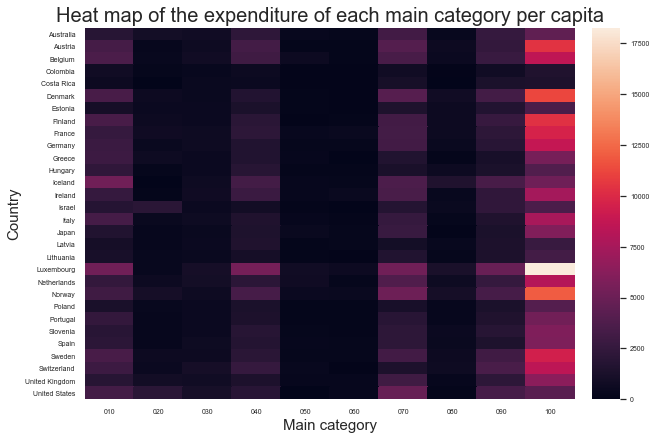

In [54]:
# heat map of the expenditure of each main category per capita
top_dataset = data.load_data(config, True)
top_clean_data = data.filter_bad_data(top_dataset)
top_samples = data.create_samples(top_clean_data)

whole_data_heat = top_samples[1].iloc[:, 0:-2]
whole_data_heat = whole_data_heat.groupby(['Country'], as_index=False).mean()
whole_data_heat = whole_data_heat.drop('Year', axis=1)
whole_data_heat = whole_data_heat.set_index('Country')
fig=plt.figure(figsize=(9,6))
sns.heatmap(whole_data_heat)

plt.title('Heat map of the expenditure of each main category per capita', fontsize = 20) # title with fontsize 20
plt.xlabel('Main category', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Country', fontsize = 15) # y-axis label with fontsize 15

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fc16a743d90>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fc16a743d90> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.figure:Executing constrainedlayout
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000117.ss000118.ax000119, (left: 0.000) (bot: 0.000) (right: 0.000) (top: 0.000)
DEBUG:matplotlib._constrained_layout:left 0.029104
DEBUG:matplotlib._constrained_layout:right 0.004630
DEBUG:matplotlib._constrained_layout:bottom 0.086665
DEBUG:matplotlib._constrained_layout:bbox.y0 0.045280
DEBUG:matplotlib._constrained_layout:pos.y0 0.125000
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000117.ss000118.cbar, (left: 0.000) (bot: 0.000) (right: 0.000) (top: 0.000)
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib._constrained_layout:left 0.004630
DEBU

Text(-0.9997600000000011, 0.5, 'Country')

DEBUG:matplotlib.figure:Executing constrainedlayout
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000117.ss000118.ax000119, (left: 0.000) (bot: 0.000) (right: 0.892) (top: 1.000)
DEBUG:matplotlib._constrained_layout:left 0.124615
DEBUG:matplotlib._constrained_layout:right 0.004630
DEBUG:matplotlib._constrained_layout:bottom 0.084491
DEBUG:matplotlib._constrained_layout:bbox.y0 0.006595
DEBUG:matplotlib._constrained_layout:pos.y0 0.084142
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000117.ss000118.cbar, (left: 0.910) (bot: 0.000) (right: 1.000) (top: 1.000)
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib._constrained_layout:left 0.004630
DEBUG:matplotlib._constrained_layout:right 0.040317
DEBUG:matplotlib._constrained_layout:bottom 0.015047
DEBUG:matplotlib._constrained_layout:bbox.y0 0.076040
DEBUG:matplotlib._constrained_layout:pos.y0 0.084142
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000117.ss000118.ax

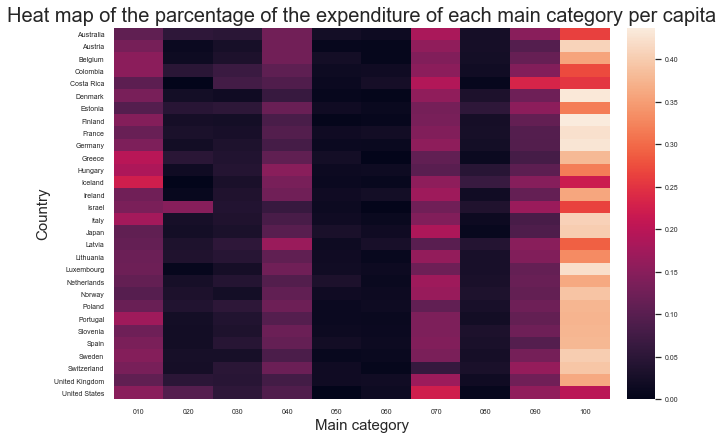

In [55]:
# heat map of the parcentage of the expenditure of each main category per capita
whole_rate_heat = top_samples[0].iloc[:, 0:-2]
whole_rate_heat = whole_rate_heat.groupby(['Country'], as_index=False).mean()
whole_rate_heat = whole_rate_heat.drop('Year', axis=1)
whole_rate_heat = whole_rate_heat.set_index('Country')

fig=plt.figure(figsize=(9,6))
sns.heatmap(whole_rate_heat)

plt.title('Heat map of the parcentage of the expenditure of each main category per capita', fontsize = 20) # title with fontsize 20
plt.xlabel('Main category', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Country', fontsize = 15) # y-axis label with fontsize 15

[17325.701666666664, 25551.326666666664, 23953.640833333335, 5569.521818181818, 5584.1466666666665, 25998.141428571427, 11105.444166666668, 23710.040000000005, 22754.67666666667, 20496.51923076923, 14530.148333333333, 12407.941666666666, 23614.92428571429, 20926.288333333334, 13585.082307692308, 18566.57307692308, 14749.1925, 9249.929166666667, 9756.005384615384, 43194.47, 22321.468333333334, 30683.97375, 10722.210000000001, 14149.173636363634, 15666.544545454544, 15255.050769230771, 23493.212307692305, 21579.307500000003, 17610.186153846156, 21317.31153846154]
[8105.699999999999, 11469.140000000003, 10650.419999999998, 3409.89, 2136.2, 12981.39, 7670.41, 8233.439999999999, 8672.66, 9272.210000000001, 2924.51, 6013.68, 7470.73, 9698.96, 5252.299999999999, 5733.830000000002, 4123.530000000001, 6005.92, 6691.840000000001, 13974.200000000004, 6321.710000000003, 10133.609999999997, 6942.74, 3589.67, 4478.270000000002, 5022.670000000002, 7025.779999999999, 6669.670000000002, 5398.2200000000

Text(0, 0.5, 'maximum, minimum and mean of the total expenditure per capita (USD)')

DEBUG:matplotlib.figure:Executing constrainedlayout
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000123.ss000124.ax000125, (left: 0.000) (bot: 0.000) (right: 0.000) (top: 0.000)
DEBUG:matplotlib._constrained_layout:left 0.076968
DEBUG:matplotlib._constrained_layout:right 0.004630
DEBUG:matplotlib._constrained_layout:bottom 0.186922
DEBUG:matplotlib._constrained_layout:bbox.y0 -0.054977
DEBUG:matplotlib._constrained_layout:pos.y0 0.125000
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000123.ss000124.ax000125, (left: 0.000) (bot: 0.000) (right: 1.000) (top: 1.000)
DEBUG:matplotlib._constrained_layout:left 0.076968
DEBUG:matplotlib._constrained_layout:right 0.004630
DEBUG:matplotlib._constrained_layout:bottom 0.186922
DEBUG:matplotlib._constrained_layout:bbox.y0 0.006945
DEBUG:matplotlib._constrained_layout:pos.y0 0.186922
DEBUG:matplotlib.figure:Executing constrainedlayout
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000123.ss000124.ax000125, (left: 0.000)

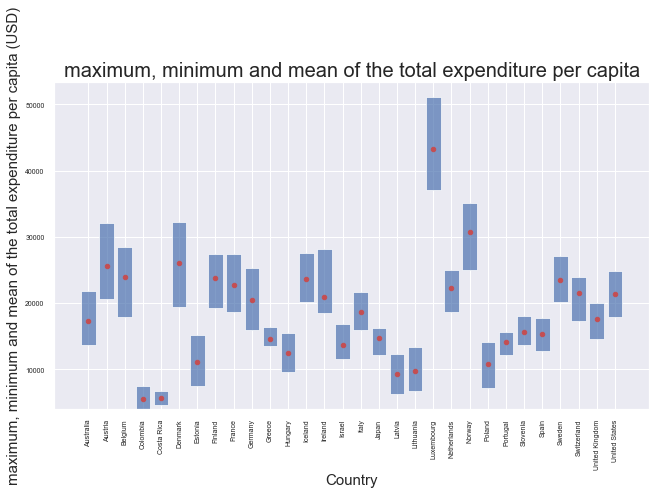

In [57]:
#maximum, minimum and mean of the total expenditure per capita
pd.set_option('display.max_rows', 5)
#print(top_samples[1])
whole_data_box = top_samples[1]
bar_mean = whole_data_box.groupby(['Country'], as_index=False)["Total expenditure per capita (1000s USD)"].mean()
bar_mean = bar_mean["Total expenditure per capita (1000s USD)"].tolist()
print(bar_mean)
bar_min = whole_data_box.groupby(['Country'], as_index=False)["Total expenditure per capita (1000s USD)"].min()
bar_min = bar_min["Total expenditure per capita (1000s USD)"].tolist()

bar_max = whole_data_box.groupby(['Country'], as_index=False)["Total expenditure per capita (1000s USD)"].max()
bar_max = bar_max["Total expenditure per capita (1000s USD)"].tolist()

array1 = np.array(bar_max)
array2 = np.array(bar_min)
subtracted_array = np.subtract(array1, array2)
subtracted = list(subtracted_array)
print(subtracted)

x = whole_data_box['Country'].unique()
fig=plt.figure(figsize=(9,6))
plt.xticks(rotation='vertical')
plt.bar(x, subtracted, width=0.8, bottom=bar_min, alpha=0.7, zorder = 1)
plt.scatter(x, bar_mean,s = 20,  c = "r", zorder = 2)

plt.title('maximum, minimum and mean of the total expenditure per capita', fontsize = 20) # title with fontsize 20
plt.xlabel('Country', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('maximum, minimum and mean of the total expenditure per capita (USD)', fontsize = 15) # y-axis label with fontsize 15

<ipython-input-58-ff3e62bd2b37>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(x, rotation=90, ha='right')
DEBUG:matplotlib.figure:Executing constrainedlayout
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000126.ss000127.ax000128, (left: 0.000) (bot: 0.000) (right: 0.000) (top: 0.000)
DEBUG:matplotlib._constrained_layout:left 0.056945
DEBUG:matplotlib._constrained_layout:right 0.004167
DEBUG:matplotlib._constrained_layout:bottom 0.015030
DEBUG:matplotlib._constrained_layout:bbox.y0 0.801582
DEBUG:matplotlib._constrained_layout:pos.y0 0.816017
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000126.ss000129.ax000130, (left: 0.000) (bot: 0.000) (right: 0.000) (top: 0.000)
DEBUG:matplotlib._constrained_layout:left 0.056945
DEBUG:matplotlib._constrained_layout:right 0.004167
DEBUG:matplotlib._constrained_layout:bottom 0.015030
DEBUG:matplotlib._constrained_layout:bbox.y0 0.724803
DEBUG:matplotlib._constrained_layout:

DEBUG:matplotlib._constrained_layout:left 0.056945
DEBUG:matplotlib._constrained_layout:right 0.004167
DEBUG:matplotlib._constrained_layout:bottom 0.015030
DEBUG:matplotlib._constrained_layout:bbox.y0 0.299883
DEBUG:matplotlib._constrained_layout:pos.y0 0.314317
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000126.ss000141.ax000142, (left: 0.005) (bot: 0.200) (right: 1.000) (top: 0.297)
DEBUG:matplotlib._constrained_layout:left 0.056945
DEBUG:matplotlib._constrained_layout:right 0.004167
DEBUG:matplotlib._constrained_layout:bottom 0.015030
DEBUG:matplotlib._constrained_layout:bbox.y0 0.200120
DEBUG:matplotlib._constrained_layout:pos.y0 0.214555
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000126.ss000143.ax000144, (left: 0.005) (bot: 0.100) (right: 1.000) (top: 0.198)
DEBUG:matplotlib._constrained_layout:left 0.056945
DEBUG:matplotlib._constrained_layout:right 0.004167
DEBUG:matplotlib._constrained_layout:bottom 0.015030
DEBUG:matplotlib._constrained_layout:bbox.y0

DEBUG:matplotlib._constrained_layout:bbox.y0 0.299883
DEBUG:matplotlib._constrained_layout:pos.y0 0.314317
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000126.ss000141.ax000142, (left: 0.005) (bot: 0.200) (right: 1.000) (top: 0.297)
DEBUG:matplotlib._constrained_layout:left 0.056849
DEBUG:matplotlib._constrained_layout:right 0.004071
DEBUG:matplotlib._constrained_layout:bottom 0.015028
DEBUG:matplotlib._constrained_layout:bbox.y0 0.200120
DEBUG:matplotlib._constrained_layout:pos.y0 0.214554
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000126.ss000143.ax000144, (left: 0.005) (bot: 0.100) (right: 1.000) (top: 0.198)
DEBUG:matplotlib._constrained_layout:left 0.056849
DEBUG:matplotlib._constrained_layout:right 0.004071
DEBUG:matplotlib._constrained_layout:bottom 0.015028
DEBUG:matplotlib._constrained_layout:bbox.y0 0.100358
DEBUG:matplotlib._constrained_layout:pos.y0 0.114792
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000126.ss000145.ax000146, (left: 0.00

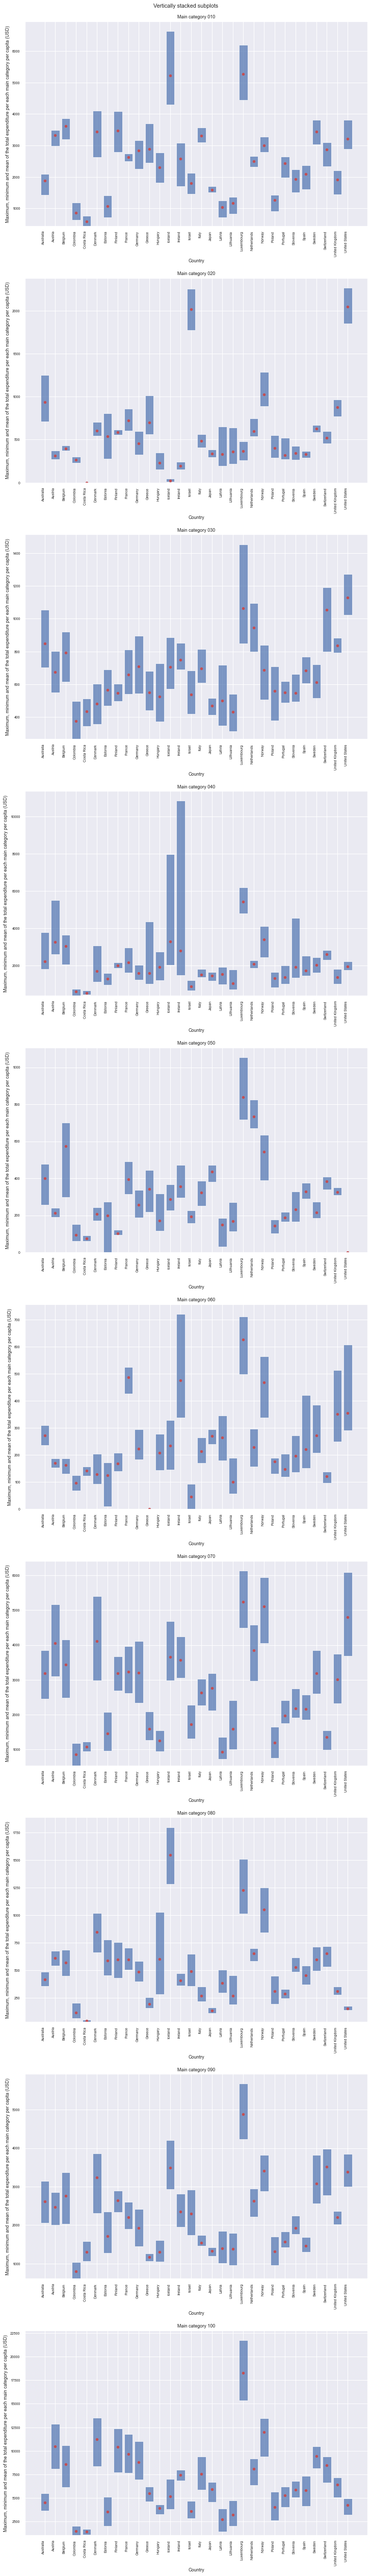

In [58]:
# plot of maximum, minimum and mean of the total expenditure of each country, each main category per capita 
list_main_category = ["010", "020", "030", "040", "050", "060", "070", "080", "090", "100"]
fig, axs = plt.subplots(10,figsize=(10, 70))
fig.suptitle('Vertically stacked subplots')
plt.xticks(rotation='vertical')
x = whole_data_box['Country'].unique()

for i, main_category in enumerate(list_main_category):
    bar_mean = whole_data_box.groupby(['Country'], as_index=False)[main_category].mean()
    bar_mean = bar_mean[main_category].tolist()
    bar_min = whole_data_box.groupby(['Country'], as_index=False)[main_category].min()
    bar_min = bar_min[main_category].tolist()
    bar_max = whole_data_box.groupby(['Country'], as_index=False)[main_category].max()
    bar_max = bar_max[main_category].tolist()
    array1 = np.array(bar_max)
    array2 = np.array(bar_min)
    subtracted_array = np.subtract(array1, array2)
    subtracted = list(subtracted_array)
    axs[i].set_xticklabels(x, rotation=90, ha='right')
    axs[i].bar(x, subtracted, width=0.8, bottom=bar_min, alpha=0.7, zorder = 1)
    axs[i].scatter(x, bar_mean,s = 20,  c = "r", zorder = 2)
    axs[i].set_xlabel("Country")
    axs[i].set_ylabel("Maximum, minimum and mean of the total expenditure per each main category per capita (USD)")
    axs[i].set_title("Main category %s" %(main_category) )
   